In [1]:
import pandas as pd
import talib
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import iisignature
from tqdm import tqdm  # For progress bar
from features import construct_features
from signature_feature import create_signature_features 
from sklearn.preprocessing import StandardScaler
from resample import resample


In [2]:
coin_df = pd.read_csv('SOLUSDC-1m-2years.csv') 

In [3]:
coin_df['timestamp'] = pd.to_datetime(coin_df['timestamp'],dayfirst=True )
coin_df.set_index('timestamp', inplace=True)

In [4]:
coin_df = resample(coin_df)

In [5]:
coin_df

,close,open,high,low,volume,quote_asset_volume,taker_buy_base_volume,taker_buy_quote_volume,number_of_trades
timestamp,,,,,,,,,
2024-01-01 00:00:00,102.47,101.55,102.47,101.55,3.640,3.696788e+02,0.040,4.098800e+00,2
2024-01-01 00:15:00,102.47,102.47,102.47,102.47,0.000,0.000000e+00,0.000,0.000000e+00,0
2024-01-01 00:30:00,102.26,102.47,102.47,101.40,30.240,3.086882e+03,21.820,2.232577e+03,15
2024-01-01 00:45:00,102.03,102.26,102.26,102.03,12.600,1.285602e+03,7.190,7.335957e+02,3
2024-01-01 01:00:00,102.37,102.03,102.37,101.51,14.660,1.492376e+03,3.180,3.255366e+02,10
...,...,...,...,...,...,...,...,...,...
2025-09-30 22:45:00,208.14,209.10,209.34,207.90,5837.142,1.217795e+06,1996.970,4.165241e+05,5218
2025-09-30 23:00:00,208.17,208.14,208.47,207.45,9585.662,1.992662e+06,4932.896,1.025112e+06,5866
2025-09-30 23:15:00,208.51,208.17,208.96,208.01,2307.264,4.810981e+05,1599.079,3.334713e+05,2706


In [6]:
new_df = construct_features(coin_df)
sig_features = create_signature_features(coin_df, window_size=100, level=2)

new_df = pd.concat([new_df, sig_features], axis=1)

Computing Rolling Signatures (Window: 100, Level: 2)...


100%|██████████| 61244/61244 [00:00<00:00, 270481.44it/s]


In [7]:
new_df = new_df.drop(columns=['Sig_0','Sig_2']) #drop constant features see report for explanation  

In [8]:
print(new_df.head())
new_df.columns.to_list()

                     open_lag_1  high_lag_1  low_lag_1  close_lag_1  \
timestamp                                                             
2024-01-01 00:00:00         NaN         NaN        NaN          NaN   
2024-01-01 00:15:00      101.55      102.47     101.55       102.47   
2024-01-01 00:30:00      102.47      102.47     102.47       102.47   
2024-01-01 00:45:00      102.47      102.47     101.40       102.26   
2024-01-01 01:00:00      102.26      102.26     102.03       102.03   

                     number_of_trades_lag_1  quote_asset_volume_lag_1  \
timestamp                                                               
2024-01-01 00:00:00                     NaN                       NaN   
2024-01-01 00:15:00                     2.0                  369.6788   
2024-01-01 00:30:00                     0.0                    0.0000   
2024-01-01 00:45:00                    15.0                 3086.8820   
2024-01-01 01:00:00                     3.0                 1285

['open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'close_lag_1',
 'number_of_trades_lag_1',
 'quote_asset_volume_lag_1',
 'taker_buy_quote_volume_lag_1',
 'volume_lag_1',
 'HminusL',
 'return_lag_1',
 'return_lag_2',
 'return_lag_3',
 'return_lag_4',
 'return_lag_5',
 'SMA',
 'correlation_sma_close',
 'sum3',
 'sum5',
 'sum3-sum5',
 'target',
 'RSI9',
 'RSI14',
 'RSI9Smaller20',
 'RSI14Smaller20',
 'RSI9Bigger80',
 'MACD1',
 'MACD2',
 'MACD3',
 'roc9',
 'roc14',
 'ewa',
 'mom5',
 'WilliamR',
 'doubleEMA',
 'ATR5',
 'ATR10',
 'aroon_stoch_k',
 'aroon_stoch_d',
 'Sig_1',
 'Sig_3',
 'Sig_4',
 'Sig_5']

In [9]:
new_df.dropna(inplace=True)

In [10]:
Y = new_df['target']
X = new_df.drop(columns = 'target')

In [11]:
from scipy import stats

corr = pd.DataFrame()
corr.index = X.columns
for col in X.columns:
    st = stats.pearsonr(X[col], Y)
    corr.loc[col, 'corr'] = st.statistic
    corr.loc[col, 'pvalue'] = st.pvalue

corr.sort_values(key = lambda x: np.abs(x), by='corr', ascending=False)

,corr,pvalue
RSI9,-0.058026,7.782411e-47
RSI14,-0.055060,2.448516e-42
sum3,-0.052503,1.193903e-38
WilliamR,0.051246,6.692190e-37
sum5,-0.049228,3.522120e-34
mom5,-0.049145,4.536026e-34
MACD3,-0.045303,3.364159e-29
MACD1,-0.041708,5.375496e-25
roc9,-0.041340,1.386097e-24
roc14,-0.037666,1.115781e-20


In [12]:
length = len(coin_df)
print(length)

61344


In [13]:
n1 = int(len(X) * 0.8)
n2 = int(len(X) * 0.9)

X_train, y_train = X[:n1], Y[:n1]
X_eval, y_eval = X[n1:n2], Y[n1:n2]
X_test, y_test = X[n2:], Y[n2:]

In [14]:
sum(y_test==0)/len(y_test)

0.49289795918367346

In [15]:
params={'learning_rate': 0.001,
        'max_depth': 8,
        'n_jobs': -1,
        'early_stopping_round':500,
        'random_state':42,
        'n_estimators':10000,
        'max_depth':64,
        #'objective': 'accuracy',
        'feature_fraction':0.5,
        #'reg_alpha':100,
        #'max_depth':-1,
        #'reg_lambda':1,
        #'lambda_l2':3.0,        
        #'lambda_l1':0.5,
        'bagging_fraction':0.5,
        'bagging_freq':2,
        'min_data_in_leaf': 20
        #'boosting_type':''
        }
LGBMmodel=LGBMClassifier(**params)
        
LGBMmodel.fit(X_train, y_train, eval_set=[(X_eval, y_eval)])

y_pred = LGBMmodel.predict(X_test)
        
print("LGBM Accuracy: ",accuracy_score(y_test, y_pred))

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 24430, number of neg

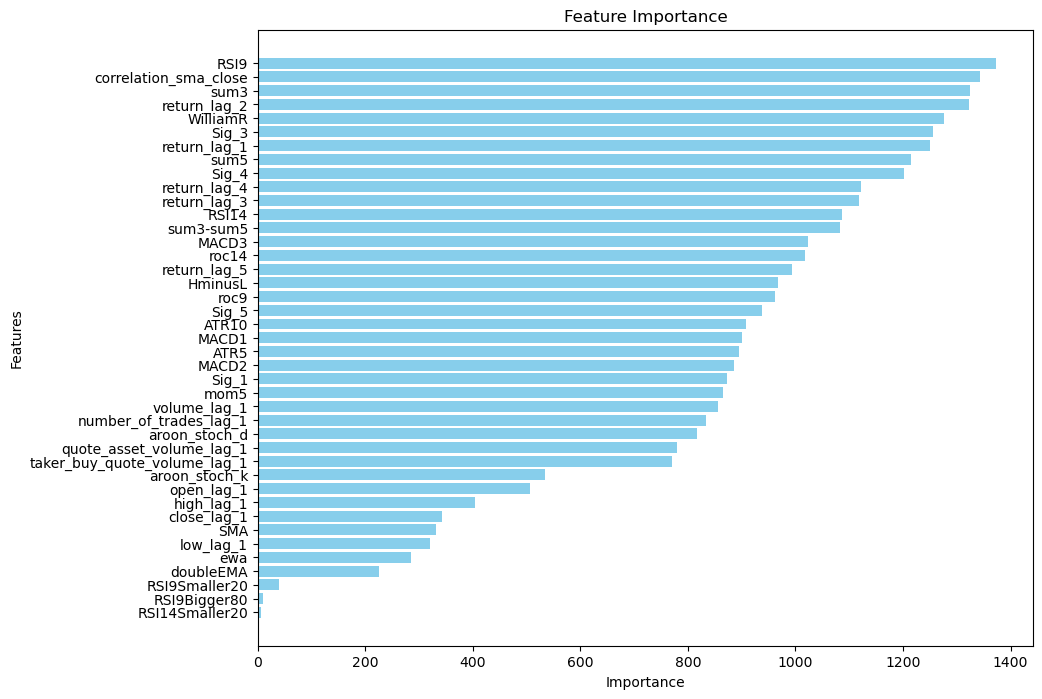

In [16]:
import matplotlib.pyplot as plt

# Extract feature importance from the LightGBM model
feature_importances = LGBMmodel.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Neural Network

In [17]:
from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
import torch

/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

model= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                scheduler_params={"step_size":10, 
                                    "gamma":0.9},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                )
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_eval_scaled, y_eval)],
    eval_name=['train', 'validation'],
    eval_metric=['accuracy'],
    max_epochs=500, patience=80,
    batch_size=512, virtual_batch_size=512,
    drop_last=False
)            

X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)
score = accuracy_score(y_test, y_pred)    
print(f"TabNet Score: {score:0.3f}")
#print(f"TabNet OOF Score: {accuracy_score(Y, oof)}")


/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7101  | train_accuracy: 0.50375 | validation_accuracy: 0.50604 |  0:00:03s
epoch 1  | loss: 0.6938  | train_accuracy: 0.51444 | validation_accuracy: 0.51176 |  0:00:07s
epoch 2  | loss: 0.69364 | train_accuracy: 0.51507 | validation_accuracy: 0.50506 |  0:00:10s
epoch 3  | loss: 0.69289 | train_accuracy: 0.5114  | validation_accuracy: 0.4982  |  0:00:14s
epoch 4  | loss: 0.69282 | train_accuracy: 0.51499 | validation_accuracy: 0.51617 |  0:00:17s
epoch 5  | loss: 0.69273 | train_accuracy: 0.49999 | validation_accuracy: 0.50718 |  0:00:21s
epoch 6  | loss: 0.69294 | train_accuracy: 0.52079 | validation_accuracy: 0.51437 |  0:00:24s
epoch 7  | loss: 0.69249 | train_accuracy: 0.52175 | validation_accuracy: 0.51519 |  0:00:28s
epoch 8  | loss: 0.69263 | train_accuracy: 0.52271 | validation_accuracy: 0.51241 |  0:00:31s
epoch 9  | loss: 0.69232 | train_accuracy: 0.51734 | validation_accuracy: 0.508   |  0:00:34s
epoch 10 | loss: 0.69236 | train_accuracy: 0.51975 | validat

/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Score: 0.518


## Logistic Regression

In [19]:
n1 = int(len(X) * 0.9)

X_train, y_train = X[:n1], Y[:n1]
X_test, y_test = X[n1:], Y[n1:]

from sklearn.linear_model import LogisticRegressionCV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegressionCV(cv=5, random_state=42, max_iter=5000)#), penalty='l1', solver='liblinear')

print("Training model and tuning C...")
clf.fit(X_train_scaled, y_train)

optimal_c = clf.C_[0]

print("-" * 30)
print(f"Optimal C value found: {optimal_c:.4f}")
print("-" * 30)

y_pred = clf.predict(X_test_scaled)
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")



Training model and tuning C...
------------------------------
Optimal C value found: 0.0008
------------------------------
Test Set Accuracy: 0.5174


In [20]:
n1 = int(len(X) * 0.9)

X_train, y_train = X[:n1], Y[:n1]
X_test, y_test = X[n1:], Y[n1:]

from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(C=0.01, max_iter=5000)


clf.fit(X_train_scaled, y_train)



y_pred = clf.predict(X_train_scaled)
print(f"Test Set Accuracy: {accuracy_score(y_train, y_pred):.4f}")

Test Set Accuracy: 0.5245
